# XGBoost multiclass

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, mean_squared_error, confusion_matrix

In [3]:
readmit_map = {'NO' : 0,
               '>30' : 1,
               '<30' : 2}

In [4]:
data = pd.read_csv('../data/data_processed.csv')

data['target'] = data['readmitted'].astype(str).map(readmit_map)

data = data.drop(columns='readmitted')

In [5]:
X = data.drop(columns = 'target')
y = data['target']

In [6]:
X['strat_col'] = X['race'].astype(str) + "_" + data['target'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

X_test_copy = X_test.copy(deep = True)

X_train = X_train.drop(columns = ['strat_col' , 'race'])
X_test = X_test.drop(columns = ['strat_col' , 'race'])

In [7]:
def custom_fit(alg, train_x, train_y, cv_folds=5, early_stopping_rounds=50):
    
    
    xgb_parameters = alg.get_xgb_params()
    xgb_train = xgboost.DMatrix(train_x.values, label=train_y.values)
    cross_val = xgboost.cv(xgb_parameters, xgb_train, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cross_val.shape[0])
    
    #fitting the training data
    alg.fit(train_x, train_y)
        
    y_pred = alg.predict(train_x)
    y_predprobs = alg.predict_proba(train_x)[:,1]
    
    print ("\nModel Report")
    print ("Cassification report:\n", classification_report(train_y, y_pred))
    print ("Accuracy : ", accuracy_score(train_y, y_pred))
    print ("AUC Score : " , roc_auc_score(train_y, y_predprobs))


In [9]:
#with a reasonable set of parameters (not calibrated)

xgb = XGBClassifier(
 learning_rate=0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=3,
 gamma=0.01,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='multi:softmax',
 n_jobs=-1,
 num_class=3,
 seed=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.85     40814
           1       0.73      0.69      0.70     27971
           2       0.88      0.26      0.41      8901

    accuracy                           0.77     77686
   macro avg       0.80      0.63      0.65     77686
weighted avg       0.78      0.77      0.75     77686



### Using grid search to tune

#### First search: `n_estimators` and `learning_rate`

In [10]:
scoring_metric = 'recall_macro'

In [11]:
%%time
best_params_GS = {}

param_test_1 = {
    'n_estimators': range(200, 1000, 200),
    'learning_rate': np.logspace(-3,0,10)
}
gsearch_1 = GridSearchCV(estimator = XGBClassifier(objective= 'multiclass:softmax', random_state = 42), 
 param_grid = param_test_1, scoring=scoring_metric,n_jobs=-1, cv=5)
gsearch_1.fit(X_train,y_train)

best_params_GS.update(gsearch_1.best_params_)
print("The best parameters are:", gsearch_1.best_params_)
print("Best", scoring_metric, "score = ",gsearch_1.best_score_)

The best parameters are: {'learning_rate': np.float64(0.21544346900318823), 'n_estimators': 600}
Best recall_macro score =  0.5589447911929349
CPU times: total: 15.4 s
Wall time: 5min 39s


#### Second search:  `subsample` and `colsample_bytree`

In [14]:
%%time

param_test_2 = {
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5)
}

gsearch_2 = GridSearchCV(estimator = XGBClassifier(**best_params_GS, objective= 'multiclass:softmax', random_state = 42), 
 param_grid = param_test_2, scoring=scoring_metric,n_jobs=-1, verbose=1, cv=5)
gsearch_2.fit(X_train,y_train)

best_params_GS.update(gsearch_2.best_params_)
print("The best parameters are:", gsearch_2.best_params_)
print("Best", scoring_metric, "score = ",gsearch_2.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
The best parameters are: {'colsample_bytree': np.float64(0.5), 'subsample': np.float64(1.0)}
Best recall_macro score =  0.5616180914278763
CPU times: total: 5.02 s
Wall time: 4min 7s


#### Third search: `max_depth` and `min_child_weight`

In [16]:
%%time

param_test_3 = {
    'max_depth': range(3, 9, 1),
    'min_child_weight': range(1, 6, 1)
}

gsearch_3 = GridSearchCV(estimator = XGBClassifier(**best_params_GS, objective= 'multiclass:softmax', random_state = 42), 
 param_grid = param_test_3, scoring=scoring_metric,n_jobs=-1, verbose=1, cv=5)
gsearch_3.fit(X_train,y_train)

best_params_GS.update(gsearch_3.best_params_)
print("The best parameters are:", gsearch_3.best_params_)
print("Best", scoring_metric, "score = ",gsearch_3.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
The best parameters are: {'max_depth': 6, 'min_child_weight': 1}
Best recall_macro score =  0.5616180914278763
CPU times: total: 38.8 s
Wall time: 3min 55s


#### Fourth search: `reg_alpha` and `reg_lambda`

In [17]:
%%time

param_test_4 = {
    'reg_alpha': np.logspace(-4,2,5),
    'reg_lambda': np.logspace(-4,2,5)
}

gsearch_4 = GridSearchCV(estimator = XGBClassifier(**best_params_GS, objective= 'multiclass:softmax', random_state = 42), 
 param_grid = param_test_4, scoring=scoring_metric,n_jobs=-1, verbose=1, cv=5)
gsearch_4.fit(X_train,y_train)

best_params_GS.update(gsearch_4.best_params_)
print("The best parameters are:", gsearch_4.best_params_)
print("Best", scoring_metric, "score = ",gsearch_4.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
The best parameters are: {'reg_alpha': np.float64(3.1622776601683795), 'reg_lambda': np.float64(0.1)}
Best recall_macro score =  0.5637387112199678
CPU times: total: 46.7 s
Wall time: 3min 12s


#### Final search: `gamma`

In [19]:
%%time

param_test_5 = {
    'gamma': np.linspace(0, 1, 10)
}

gsearch_5 = GridSearchCV(estimator = XGBClassifier(**best_params_GS, objective= 'multiclass:softmax', random_state = 42), 
 param_grid = param_test_5, scoring=scoring_metric,n_jobs=-1, cv=5)
gsearch_5.fit(X_train,y_train)

best_params_GS.update(gsearch_5.best_params_)
print("The best parameters are:", gsearch_5.best_params_)
print("Best", scoring_metric, "score = ",gsearch_5.best_score_)

The best parameters are: {'gamma': np.float64(0.0)}
Best recall_macro score =  0.5637387112199678
CPU times: total: 48.2 s
Wall time: 1min 3s


In [20]:
#final list of tuned parameters
best_params_GS

{'learning_rate': np.float64(0.21544346900318823),
 'n_estimators': 600,
 'colsample_bytree': np.float64(0.5),
 'subsample': np.float64(1.0),
 'max_depth': 6,
 'min_child_weight': 1,
 'reg_alpha': np.float64(3.1622776601683795),
 'reg_lambda': np.float64(0.1),
 'gamma': np.float64(0.0)}

### Alternate: Using Random Search

In [21]:
%%time

parameters = {
    'max_depth': range(3, 11, 1),
    'min_child_weight': range(1, 11, 1),
    'gamma': np.linspace(0, 1, 10),
    'subsample': np.linspace(0.5, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 10),
    'n_estimators': range(200, 1000, 200),
    'learning_rate': np.logspace(-3,0,10),
    'reg_alpha': np.logspace(-4,2,10),
    'reg_lambda': np.logspace(-4,2,10)
}

xgb = XGBClassifier(objective= 'multiclass:softmax', num_class=3, random_state = 42)

random_search = RandomizedSearchCV(estimator = xgb, n_iter = 50,
                           param_distributions=parameters,
                           scoring = 'recall_macro',
                           n_jobs=-1, verbose=1, cv=3)

random_search.fit(X_train, y_train)

best_params_RS = random_search.best_params_

print("Best parameters:\n",random_search.best_params_,"\n")
print("Best", scoring_metric, "score = ",random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters:
 {'subsample': np.float64(0.8888888888888888), 'reg_lambda': np.float64(4.641588833612772), 'reg_alpha': np.float64(0.0001), 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': np.float64(0.21544346900318823), 'gamma': np.float64(0.4444444444444444), 'colsample_bytree': np.float64(1.0)} 

Best recall_macro score =  0.5593434561010974
CPU times: total: 20.5 s
Wall time: 3min 48s


In this case, the grid search managed to get a better AUC score, so we will stick with the parameters.

In [22]:
best_params_RS

{'subsample': np.float64(0.8888888888888888),
 'reg_lambda': np.float64(4.641588833612772),
 'reg_alpha': np.float64(0.0001),
 'n_estimators': 200,
 'min_child_weight': 4,
 'max_depth': 7,
 'learning_rate': np.float64(0.21544346900318823),
 'gamma': np.float64(0.4444444444444444),
 'colsample_bytree': np.float64(1.0)}

In [46]:
def_params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}   

In [52]:
best_params = best_params_GS#def_params

### Final fit and evaluation

In [53]:
xgbCal = XGBClassifier(**best_params, objective = 'multiclass:softmax', num_class=3, random_state=42, n_jobs=-1)

#custom_fit(xgbCal, X_train, y_train)
xgbCal.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.5), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=np.float64(0.0),
              grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.21544346900318823), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1, num_class=3,
              num_parallel_tree=None, ...)

In [54]:
probs = xgbCal.predict_proba(X_test)
y_pred = (probs[:, 1]>=0.5)

In [55]:
mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Mean squared error = ",mse)
print("Accuracy = ",acc)

Confusion Matrix:
[[9429  775    0]
 [2889 4104    0]
 [ 940 1285    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80     10204
           1       0.67      0.59      0.62      6993
           2       0.00      0.00      0.00      2225

    accuracy                           0.70     19422
   macro avg       0.46      0.50      0.48     19422
weighted avg       0.61      0.70      0.65     19422

Mean squared error =  0.44840902069817734
Accuracy =  0.6967871485943775


c:\Users\Souradeep\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Souradeep\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Souradeep\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

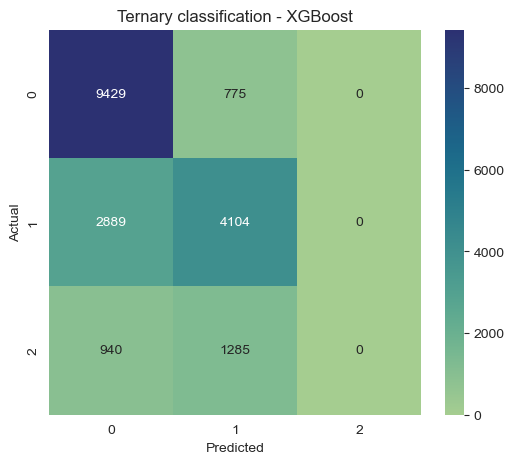

Confusion Matrix:
 [[9429  775    0]
 [2889 4104    0]
 [ 940 1285    0]]


In [58]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ternary classification - XGBoost')

plt.savefig('./figs/bal_conf_mat_xgb_3.png')
plt.show()

# Print confusion matrix and classification report for detailed metrics
print("Confusion Matrix:\n", cm)

In [57]:
feat_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgbCal.feature_importances_
}).sort_values(by='Importance', ascending=False)

feat_importances

,Feature,Importance
49,pt_diag_ct,0.129262
85,pt_inp_tot,0.120560
7,number_inpatient,0.061101
87,pt_diag_tot,0.052383
24,discharge_none_ind,0.017724
...,...,...
30,hispanic_ind,0.005103
65,d_congenital_ind,0.004802
78,pt_admission_source_2_ct,0.000722
26,admission_source_2,0.000000
